In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src") if "../src" not in sys.path else None 

from CANN_burak_jax import CANN_burak, forward_jit

In [3]:
model = CANN_burak(Ng=128*128, l = 1)

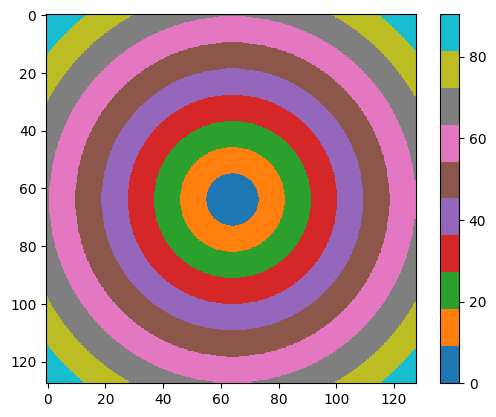

In [4]:
# plot norm of neural sheet coordinates
plt.imshow(np.linalg.norm(model.sheet, axis = -1), cmap = "tab10") # completely uninformative cmap
plt.colorbar()

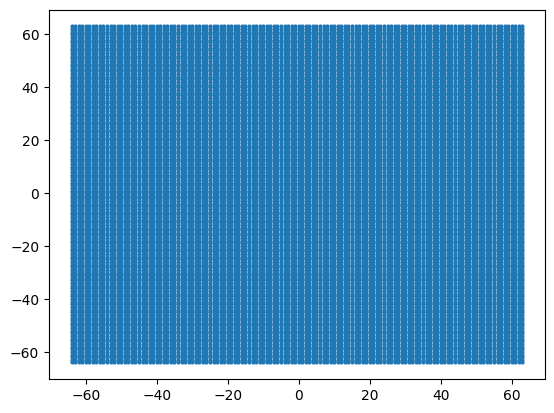

In [5]:
plt.plot(model.sheet[...,0].ravel(), model.sheet[...,1].ravel(), "o", markersize = 2)

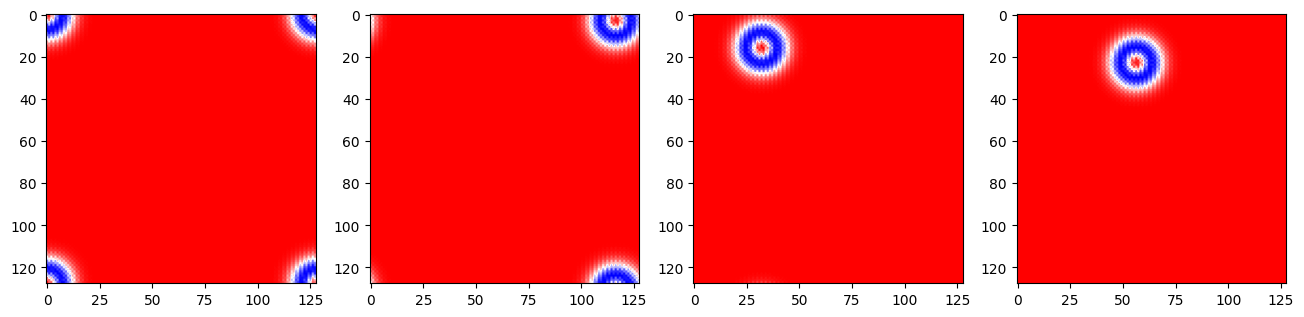

In [6]:
w = model.init_periodic_recurrent_weights(model.sheet)

show_cells = [0, 500, 2080,  3000]
fig, axs = plt.subplots(1, len(show_cells), figsize = (16, 16))

for i, cell in enumerate(show_cells):
    axs[i].imshow(w[cell].reshape((model.nl, model.nl)), cmap = "bwr")
plt.show()

In [7]:
y = model.init_shifts()
y.shape

(128, 128, 2)

In [8]:
# print some units for sanity
for i in range(4):
    for j in range(4):
        print(y[i,j], end = "")
    print('\n')

[ 1. -0.][-1.  0.][ 1. -0.][-1.  0.]

[-0.  1.][ 0. -1.][-0.  1.][ 0. -1.]

[ 1. -0.][-1.  0.][ 1. -0.][-1.  0.]

[-0.  1.][ 0. -1.][-0.  1.][ 0. -1.]



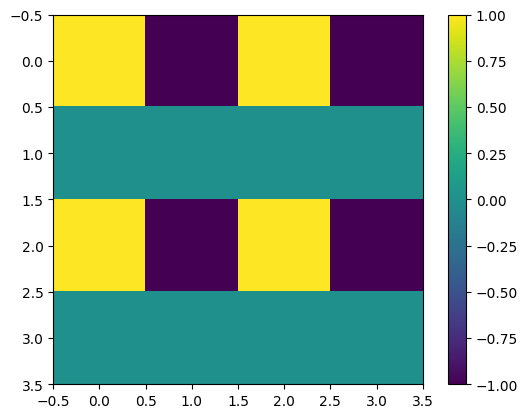

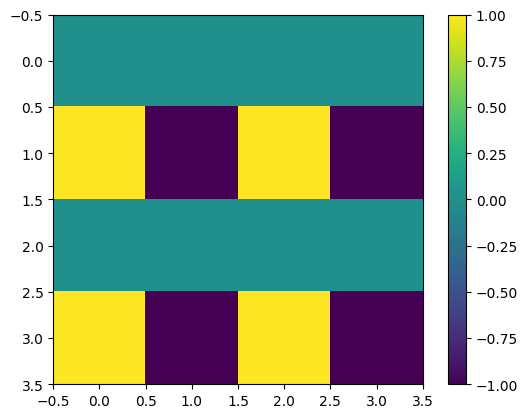

In [9]:
# plot sum of shifts along last axis (should be +1 or -1)
plt.imshow(y[:4,:4,0])
plt.colorbar();
plt.show()
plt.imshow(y[:4,:4,1])
plt.colorbar();

In [10]:
init_state = np.random.uniform(0, 1, (model.nl, model.nl))
h = np.ravel(init_state)

v0 = np.array([0,1])*0

100%|██████████| 5000/5000 [05:36<00:00, 14.86it/s]


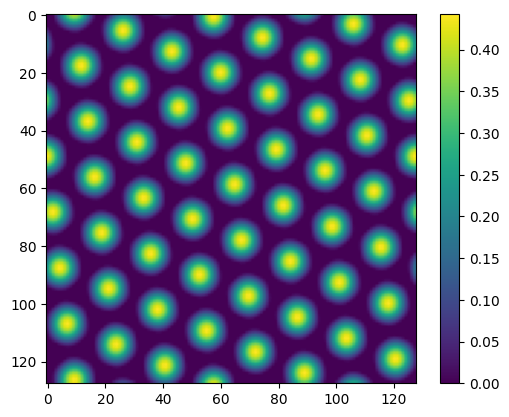

In [11]:
import tqdm
for i in tqdm.trange(5_000):
    h = forward_jit(h, v0, model.wr, model.shift.reshape(-1,2), model.alpha, model.tc)
plt.imshow(h.reshape((model.nl, model.nl)))
plt.colorbar()

In [12]:
class DatasetMaker(object):
    # Simple dataset maker; square box + bounce off walls
    def __init__(self, box_size = 2*np.pi, von_mises_scale = 4*np.pi, rayleigh_scale = 0.15):
        self.box_size = box_size # box_size x box_size enviroment
        self.von_mises_scale = von_mises_scale
        self.rayleigh_scale = rayleigh_scale

    def bounce(self, r, v):
        # bounce off walls if next step lands outside
        outside = np.abs(r + v) >= self.box_size
        v[outside] = -v[outside]
        return v

    def generate_data(self, samples, timesteps, device = "cpu"):
        r = np.zeros((samples, timesteps, 2)) # positions
        s = np.random.rayleigh(self.rayleigh_scale, (samples, timesteps)) # speeds

        # initial conditions
        prev_hd = np.random.uniform(0, 2*np.pi, samples) # previous head direction
        r[:,0] = np.random.uniform(-self.box_size, self.box_size, (samples, 2))

        for i in range(timesteps - 1):
            hd = np.random.vonmises(prev_hd, self.von_mises_scale, samples)
            prop_v = s[:,i,None]*np.stack((np.cos(hd), np.sin(hd)),axis=-1)
            v = self.bounce(r[:,i], prop_v)
            prev_hd = np.arctan2(v[:,1], v[:,0])
            r[:,i+1] = r[:,i] + v

        v = np.diff(r, axis = 1) # velocities
        return r, v

(1, 19999, 2) (1, 20000, 2)


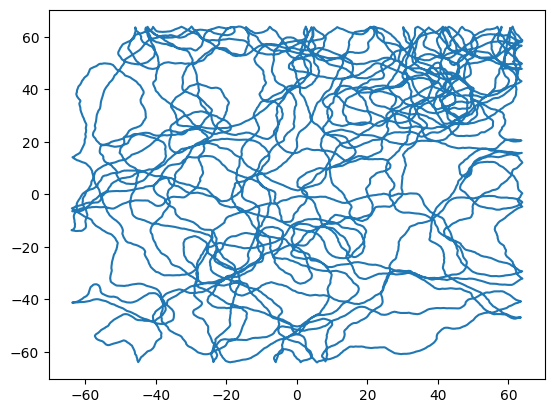

In [13]:
nsteps = 20000

dataset = DatasetMaker(model.nl*10, von_mises_scale=10*np.pi, rayleigh_scale=5)
r, v = dataset.generate_data(1, nsteps)
print(v.shape, r.shape)
eps = 0.05
r = r[0]*eps
v = v[0]*eps
plt.plot(r[:,0], r[:,1])

In [14]:
np.linalg.norm(v, axis=-1)*model.alpha

array([0.01467005, 0.01242763, 0.0293207 , ..., 0.04045909, 0.00583268,
       0.05126068])

In [15]:
ind = int((model.nl + 1)*model.nl/2)
# hs = [np.copy(h)[ind]]
hs = np.zeros((nsteps, model.nl*model.nl))
hs[0] = np.copy(h)
hi = np.copy(h)

for i in tqdm.trange(nsteps-1):
    hi = forward_jit(hi, v[i], model.wr, model.shift.reshape(-1, 2), model.alpha, model.tc)
    hs[i] = np.copy(hi)

100%|██████████| 19999/19999 [20:56<00:00, 15.92it/s]


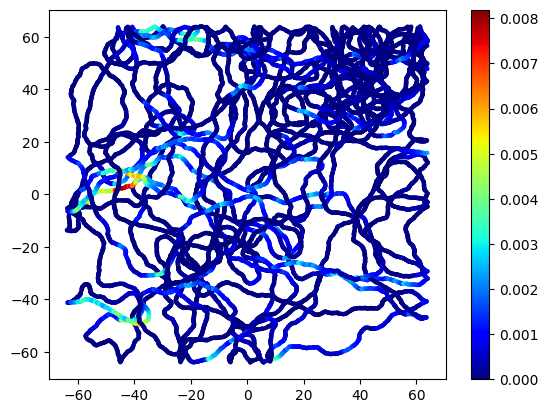

In [16]:
hs[0].shape
plt.scatter(r[:nsteps-1,0], r[:nsteps-1,1], c = hs[:nsteps-1, 0], s = 5, cmap = "jet")
plt.colorbar()

In [19]:
from scipy import stats

In [20]:
res = stats.binned_statistic_2d(r[:nsteps-1,0], r[:nsteps-1,1], np.array(hs[:nsteps-1]).T, bins = 32)[0]

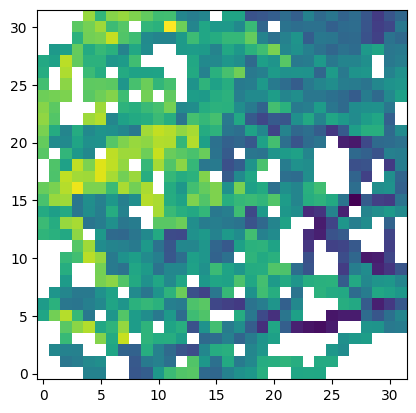

In [21]:
plt.imshow(res[4].T, origin = "lower")